In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): w


Параметры пучков и спектры

In [2]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [3]:
m = 40
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

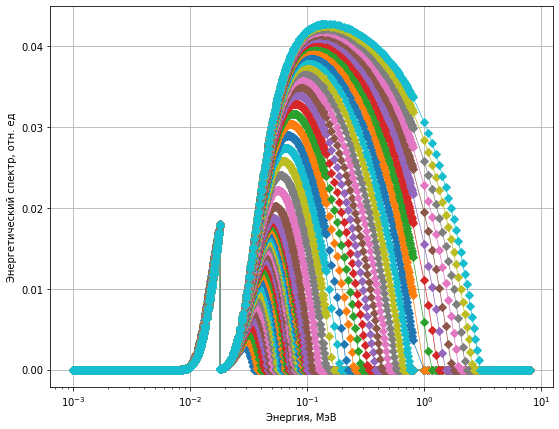

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

Номер первого канала и К-скачки

In [5]:
n = 11

In [6]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [7]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Уровни пропускания в К-крае

In [8]:
linspace3 = np.linspace(0.001, 0.9, 101)
for i, val in enumerate(linspace3):
    linspace3[i] = round(val, 5)
    
edge_max_values = []
edge_max_values.extend(linspace3)

Спектральные характеристики чувствительности каналов

In [9]:
edge_thiknesses = [[Material(i).lt(j) for i in range(n, 101)] for j in edge_max_values]

In [10]:
edge_regions = [[R(Material(i+n), edge_thiknesses[j][i]) for i in range(0, len(edge_thiknesses[j]))] for j in range(len(edge_thiknesses))]
resp_edges = [[val.f() for val in edge_regions[j]] for j in range(len(edge_regions))]

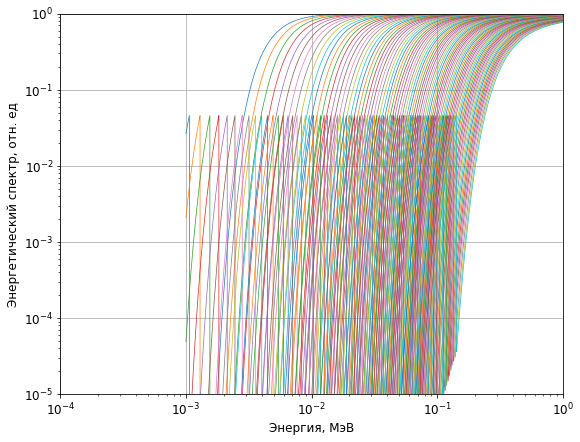

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges[5]:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Матрицы задач

In [12]:
from garipov_deconvolution import get_coeff_simpson

In [13]:
Matrixs = []

start_time = time.time()

for i in range(len(resp_edges)):
    print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
    matrix = []
    
    for response in resp_edges[i]:
        matrix.append(get_coeff_simpson(response, en, EDGE)[0])
    
    Matrixs.append(matrix)

(0), время: 0.0 секунд
(1), время: 3.11665 секунд
(2), время: 6.10883 секунд
(3), время: 9.16409 секунд
(4), время: 12.25574 секунд
(5), время: 15.23063 секунд
(6), время: 18.33967 секунд
(7), время: 21.31891 секунд
(8), время: 24.38598 секунд
(9), время: 27.71141 секунд
(10), время: 31.16408 секунд
(11), время: 34.36376 секунд
(12), время: 37.42817 секунд
(13), время: 40.44206 секунд
(14), время: 43.53481 секунд
(15), время: 46.66189 секунд
(16), время: 49.76143 секунд
(17), время: 53.05067 секунд
(18), время: 56.24364 секунд
(19), время: 59.25058 секунд
(20), время: 62.32326 секунд
(21), время: 65.29588 секунд
(22), время: 68.29212 секунд
(23), время: 71.3134 секунд
(24), время: 74.26407 секунд
(25), время: 77.16637 секунд
(26), время: 80.24013 секунд
(27), время: 83.3532 секунд
(28), время: 86.35983 секунд
(29), время: 89.37606 секунд
(30), время: 92.37757 секунд
(31), время: 95.48627 секунд
(32), время: 98.572 секунд
(33), время: 101.58133 секунд
(34), время: 104.65499 секунд
(35),

Сигналы измерительных каналов

In [14]:
new_en = get_coeff_simpson(resp_edges[0][0], en, EDGE)[1]

In [15]:
def signals_from_one_spectrum(spectrum):
    
    start_time = time.time()
    signals_simpson = []
    
    # для каждой матрицы
    for i, matrix in enumerate(Matrixs):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        
        # сигналы для каждой задачи
        signals = []
        
        # для каждой строки в матрице
        for row in matrix:
            # значение одного сигнала
            signal = sum(row * np.interp(new_en, en, spectrum))
            signals.append(signal)
            
        signals_simpson.append(signals)
        
    return signals_simpson

Сигналы для каждого спектра

In [16]:
spectrums_signals = []

for spectrum in brems_e:
    spectrums_signals.append(signals_from_one_spectrum(spectrum))

(0), время: 0.0 секунд
(1), время: 0.03092 секунд
(2), время: 0.05588 секунд
(3), время: 0.08713 секунд
(4), время: 0.11837 секунд
(5), время: 0.16304 секунд
(6), время: 0.19296 секунд
(7), время: 0.23086 секунд
(8), время: 0.26078 секунд
(9), время: 0.29468 секунд
(10), время: 0.3256 секунд
(11), время: 0.35652 секунд
(12), время: 0.39841 секунд
(13), время: 0.43431 секунд
(14), время: 0.4772 секунд
(15), время: 0.51909 секунд
(16), время: 0.56197 секунд
(17), время: 0.59688 секунд
(18), время: 0.64179 секунд
(19), время: 0.68969 секунд
(20), время: 0.72094 секунд
(21), время: 0.75218 секунд
(22), время: 0.78343 секунд
(23), время: 0.81467 секунд
(24), время: 0.86086 секунд
(25), время: 0.90075 секунд
(26), время: 0.92273 секунд
(27), время: 0.95397 секунд
(28), время: 0.98522 секунд
(29), время: 1.02428 секунд
(30), время: 1.05619 секунд
(31), время: 1.08711 секунд
(32), время: 1.12304 секунд
(33), время: 1.15429 секунд
(34), время: 1.18553 секунд
(35), время: 1.22317 секунд
(36), вр

(94), время: 3.16623 секунд
(95), время: 3.20213 секунд
(96), время: 3.21879 секунд
(97), время: 3.25003 секунд
(98), время: 3.28127 секунд
(99), время: 3.31252 секунд
(100), время: 3.34376 секунд
(0), время: 0.0 секунд
(1), время: 0.02396 секунд
(2), время: 0.05521 секунд
(3), время: 0.10207 секунд
(4), время: 0.14893 секунд
(5), время: 0.18018 секунд
(6), время: 0.22705 секунд
(7), время: 0.25699 секунд
(8), время: 0.27262 секунд
(9), время: 0.30386 секунд
(10), время: 0.3351 секунд
(11), время: 0.36634 секунд
(12), время: 0.39759 секунд
(13), время: 0.4347 секунд
(14), время: 0.47364 секунд
(15), время: 0.50488 секунд
(16), время: 0.55175 секунд
(17), время: 0.56737 секунд
(18), время: 0.59861 секунд
(19), время: 0.62985 секунд
(20), время: 0.67118 секунд
(21), время: 0.70578 секунд
(22), время: 0.73702 секунд
(23), время: 0.76827 секунд
(24), время: 0.79951 секунд
(25), время: 0.83075 секунд
(26), время: 0.86199 секунд
(27), время: 0.89666 секунд
(28), время: 0.92362 секунд
(29), в

(87), время: 2.86426 секунд
(88), время: 2.89717 секунд
(89), время: 2.91716 секунд
(90), время: 2.96402 секунд
(91), время: 2.99527 секунд
(92), время: 3.02651 секунд
(93), время: 3.05775 секунд
(94), время: 3.09878 секунд
(95), время: 3.13341 секунд
(96), время: 3.16465 секунд
(97), время: 3.19589 секунд
(98), время: 3.22713 секунд
(99), время: 3.274 секунд
(100), время: 3.31688 секунд
(0), время: 0.0 секунд
(1), время: 0.01766 секунд
(2), время: 0.0489 секунд
(3), время: 0.08015 секунд
(4), время: 0.11139 секунд
(5), время: 0.14263 секунд
(6), время: 0.19279 секунд
(7), время: 0.21876 секунд
(8), время: 0.25 секунд
(9), время: 0.28125 секунд
(10), время: 0.31249 секунд
(11), время: 0.34373 секунд
(12), время: 0.3906 секунд
(13), время: 0.42343 секунд
(14), время: 0.46701 секунд
(15), время: 0.49826 секунд
(16), время: 0.5295 секунд
(17), время: 0.56074 секунд
(18), время: 0.57636 секунд
(19), время: 0.60761 секунд
(20), время: 0.65888 секунд
(21), время: 0.68485 секунд
(22), время: 

(83), время: 2.79312 секунд
(84), время: 2.82207 секунд
(85), время: 2.85332 секунд
(86), время: 2.86894 секунд
(87), время: 2.90018 секунд
(88), время: 2.93142 секунд
(89), время: 2.96266 секунд
(90), время: 3.00753 секунд
(91), время: 3.03745 секунд
(92), время: 3.0541 секунд
(93), время: 3.08534 секунд
(94), время: 3.11658 секунд
(95), время: 3.14783 секунд
(96), время: 3.17907 секунд
(97), время: 3.22452 секунд
(98), время: 3.25547 секунд
(99), время: 3.28672 секунд
(100), время: 3.31796 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.04686 секунд
(3), время: 0.0938 секунд
(4), время: 0.12276 секунд
(5), время: 0.15401 секунд
(6), время: 0.18525 секунд
(7), время: 0.21649 секунд
(8), время: 0.24773 секунд
(9), время: 0.27897 секунд
(10), время: 0.31022 секунд
(11), время: 0.34503 секунд
(12), время: 0.37166 секунд
(13), время: 0.40291 секунд
(14), время: 0.43415 секунд
(15), время: 0.46539 секунд
(16), время: 0.49663 секунд
(17), время: 0.5349 секунд
(18), вр

(79), время: 2.65381 секунд
(80), время: 2.68473 секунд
(81), время: 2.70537 секунд
(82), время: 2.73661 секунд
(83), время: 2.76786 секунд
(84), время: 2.7991 секунд
(85), время: 2.84596 секунд
(86), время: 2.88535 секунд
(87), время: 2.90633 секунд
(88), время: 2.93757 секунд
(89), время: 2.96882 секунд
(90), время: 3.00006 секунд
(91), время: 3.0313 секунд
(92), время: 3.06254 секунд
(93), время: 3.10138 секунд
(94), время: 3.13329 секунд
(95), время: 3.15594 секунд
(96), время: 3.18718 секунд
(97), время: 3.21842 секунд
(98), время: 3.24967 секунд
(99), время: 3.28091 секунд
(100), время: 3.31627 секунд
(0), время: 0.0 секунд
(1), время: 0.02364 секунд
(2), время: 0.05489 секунд
(3), время: 0.08613 секунд
(4), время: 0.11737 секунд
(5), время: 0.14861 секунд
(6), время: 0.16423 секунд
(7), время: 0.21024 секунд
(8), время: 0.24092 секунд
(9), время: 0.27216 секунд
(10), время: 0.3034 секунд
(11), время: 0.33464 секунд
(12), время: 0.36589 секунд
(13), время: 0.39713 секунд
(14), вр

(76), время: 2.50916 секунд
(77), время: 2.53712 секунд
(78), время: 2.56836 секунд
(79), время: 2.5996 секунд
(80), время: 2.63085 секунд
(81), время: 2.66209 секунд
(82), время: 2.69333 секунд
(83), время: 2.70895 секунд
(84), время: 2.7536 секунд
(85), время: 2.77059 секунд
(86), время: 2.80184 секунд
(87), время: 2.83308 секунд
(88), время: 2.86432 секунд
(89), время: 2.89557 секунд
(90), время: 2.92681 секунд
(91), время: 2.95805 секунд
(92), время: 2.99939 секунд
(93), время: 3.01904 секунд
(94), время: 3.05028 секунд
(95), время: 3.08152 секунд
(96), время: 3.11277 секунд
(97), время: 3.15963 секунд
(98), время: 3.19358 секунд
(99), время: 3.21921 секунд
(100), время: 3.26608 секунд
(0), время: 0.0 секунд
(1), время: 0.04686 секунд
(2), время: 0.07811 секунд
(3), время: 0.12314 секунд
(4), время: 0.15609 секунд
(5), время: 0.18733 секунд
(6), время: 0.21857 секунд
(7), время: 0.24982 секунд
(8), время: 0.28106 секунд
(9), время: 0.3123 секунд
(10), время: 0.35421 секунд
(11), вр

(74), время: 2.61036 секунд
(75), время: 2.65025 секунд
(76), время: 2.68653 секунд
(77), время: 2.71777 секунд
(78), время: 2.74902 секунд
(79), время: 2.78026 секунд
(80), время: 2.81636 секунд
(81), время: 2.84827 секунд
(82), время: 2.87091 секунд
(83), время: 2.90216 секунд
(84), время: 2.9334 секунд
(85), время: 2.96464 секунд
(86), время: 2.99588 секунд
(87), время: 3.0518 секунд
(88), время: 3.08741 секунд
(89), время: 3.11866 секунд
(90), время: 3.1499 секунд
(91), время: 3.19676 секунд
(92), время: 3.228 секунд
(93), время: 3.27438 секунд
(94), время: 3.30535 секунд
(95), время: 3.33659 секунд
(96), время: 3.36783 секунд
(97), время: 3.39907 секунд
(98), время: 3.43033 секунд
(99), время: 3.47718 секунд
(100), время: 3.51132 секунд
(0), время: 0.0 секунд
(1), время: 0.03124 секунд
(2), время: 0.06248 секунд
(3), время: 0.09373 секунд
(4), время: 0.12497 секунд
(5), время: 0.16817 секунд
(6), время: 0.18416 секунд
(7), время: 0.23103 секунд
(8), время: 0.26227 секунд
(9), врем

(66), время: 2.22628 секунд
(67), время: 2.2552 секунд
(68), время: 2.27519 секунд
(69), время: 2.30644 секунд
(70), время: 2.33768 секунд
(71), время: 2.36892 секунд
(72), время: 2.40016 секунд
(73), время: 2.43751 секунд
(74), время: 2.47544 секунд
(75), время: 2.52231 секунд
(76), время: 2.56917 секунд
(77), время: 2.58479 секунд
(78), время: 2.61603 секунд
(79), время: 2.66255 секунд
(80), время: 2.6915 секунд
(81), время: 2.72275 секунд
(82), время: 2.78523 секунд
(83), время: 2.8321 секунд
(84), время: 2.88334 секунд
(85), время: 2.9083 секунд
(86), время: 2.93955 секунд
(87), время: 2.97079 секунд
(88), время: 3.00203 секунд
(89), время: 3.03328 секунд
(90), время: 3.06452 секунд
(91), время: 3.11795 секунд
(92), время: 3.14193 секунд
(93), время: 3.17317 секунд
(94), время: 3.20441 секунд
(95), время: 3.25128 секунд
(96), время: 3.28252 секунд
(97), время: 3.31376 секунд
(98), время: 3.35003 секунд
(99), время: 3.39062 секунд
(100), время: 3.42187 секунд
(0), время: 0.0 секунд


(64), время: 2.13058 секунд
(65), время: 2.1615 секунд
(66), время: 2.19012 секунд
(67), время: 2.22137 секунд
(68), время: 2.23699 секунд
(69), время: 2.26823 секунд
(70), время: 2.29947 секунд
(71), время: 2.34331 секунд
(72), время: 2.37427 секунд
(73), время: 2.40551 секунд
(74), время: 2.43675 секунд
(75), время: 2.45238 секунд
(76), время: 2.48362 секунд
(77), время: 2.51486 секунд
(78), время: 2.55815 секунд
(79), время: 2.59111 секунд
(80), время: 2.62236 секунд
(81), время: 2.6536 секунд
(82), время: 2.70046 секунд
(83), время: 2.73171 секунд
(84), время: 2.76685 секунд
(85), время: 2.79876 секунд
(86), время: 2.82341 секунд
(87), время: 2.85466 секунд
(88), время: 2.8859 секунд
(89), время: 2.91714 секунд
(90), время: 2.94838 секунд
(91), время: 2.97962 секунд
(92), время: 3.01499 секунд
(93), время: 3.03963 секунд
(94), время: 3.07087 секунд
(95), время: 3.10212 секунд
(96), время: 3.13336 секунд
(97), время: 3.1646 секунд
(98), время: 3.20037 секунд
(99), время: 3.22436 сек

(57), время: 1.88019 секунд
(58), время: 1.9171 секунд
(59), время: 1.93707 секунд
(60), время: 1.96832 секунд
(61), время: 1.99956 секунд
(62), время: 2.0308 секунд
(63), время: 2.06204 секунд
(64), время: 2.10411 секунд
(65), время: 2.13603 секунд
(66), время: 2.16831 секунд
(67), время: 2.19955 секунд
(68), время: 2.2308 секунд
(69), время: 2.26204 секунд
(70), время: 2.29329 секунд
(71), время: 2.32728 секунд
(72), время: 2.35325 секунд
(73), время: 2.40011 секунд
(74), время: 2.43136 секунд
(75), время: 2.47822 секунд
(76), время: 2.50946 секунд
(77), время: 2.55002 секунд
(78), время: 2.58094 секунд
(79), время: 2.60258 секунд
(80), время: 2.63383 секунд
(81), время: 2.66507 секунд
(82), время: 2.69632 секунд
(83), время: 2.72755 секунд
(84), время: 2.77568 секунд
(85), время: 2.80364 секунд
(86), время: 2.83488 секунд
(87), время: 2.86612 секунд
(88), время: 2.89737 секунд
(89), время: 2.92861 секунд
(90), время: 2.95985 секунд
(91), время: 2.99763 секунд
(92), время: 3.03658 се

(53), время: 2.22461 секунд
(54), время: 2.2675 секунд
(55), время: 2.30112 секунд
(56), время: 2.34798 секунд
(57), время: 2.39484 секунд
(58), время: 2.45772 секунд
(59), время: 2.5013 секунд
(60), время: 2.54817 секунд
(61), время: 2.59503 секунд
(62), время: 2.64189 секунд
(63), время: 2.69572 секунд
(64), время: 2.73434 секунд
(65), время: 2.7812 секунд
(66), время: 2.82807 секунд
(67), время: 2.87493 секунд
(68), время: 2.92272 секунд
(69), время: 2.95268 секунд
(70), время: 2.99954 секунд
(71), время: 3.03078 секунд
(72), время: 3.07765 секунд
(73), время: 3.10889 секунд
(74), время: 3.15475 секунд
(75), время: 3.18439 секунд
(76), время: 3.23125 секунд
(77), время: 3.26249 секунд
(78), время: 3.29373 секунд
(79), время: 3.3406 секунд
(80), время: 3.38723 секунд
(81), время: 3.43372 секунд
(82), время: 3.48058 секунд
(83), время: 3.51183 секунд
(84), время: 3.55869 секунд
(85), время: 3.60164 секунд
(86), время: 3.6356 секунд
(87), время: 3.66684 секунд
(88), время: 3.7137 секун

(47), время: 1.91615 секунд
(48), время: 1.95609 секунд
(49), время: 2.00296 секунд
(50), время: 2.0342 секунд
(51), время: 2.08107 секунд
(52), время: 2.12793 секунд
(53), время: 2.1712 секунд
(54), время: 2.20349 секунд
(55), время: 2.23473 секунд
(56), время: 2.28159 секунд
(57), время: 2.33907 секунд
(58), время: 2.38764 секунд
(59), время: 2.41888 секунд
(60), время: 2.46575 секунд
(61), время: 2.49699 секунд
(62), время: 2.55081 секунд
(63), время: 2.58875 секунд
(64), время: 2.61999 секунд
(65), время: 2.66686 секунд
(66), время: 2.71372 секунд
(67), время: 2.76059 секунд
(68), время: 2.80475 секунд
(69), время: 2.83705 секунд
(70), время: 2.88391 секунд
(71), время: 2.91515 секунд
(72), время: 2.96201 секунд
(73), время: 3.00944 секунд
(74), время: 3.0537 секунд
(75), время: 3.10057 секунд
(76), время: 3.13181 секунд
(77), время: 3.19429 секунд
(78), время: 3.24053 секунд
(79), время: 3.27248 секунд
(80), время: 3.30372 секунд
(81), время: 3.35059 секунд
(82), время: 3.38183 се

(42), время: 1.64477 секунд
(43), время: 1.68267 секунд
(44), время: 1.70731 секунд
(45), время: 1.73856 секунд
(46), время: 1.78542 секунд
(47), время: 1.83228 секунд
(48), время: 1.88099 секунд
(49), время: 1.90796 секунд
(50), время: 1.95483 секунд
(51), время: 2.00169 секунд
(52), время: 2.04856 секунд
(53), время: 2.09542 секунд
(54), время: 2.14148 секунд
(55), время: 2.17272 секунд
(56), время: 2.21958 секунд
(57), время: 2.25083 секунд
(58), время: 2.29769 секунд
(59), время: 2.34171 секунд
(60), время: 2.38858 секунд
(61), время: 2.43544 секунд
(62), время: 2.48231 секунд
(63), время: 2.52445 секунд
(64), время: 2.5584 секунд
(65), время: 2.58965 секунд
(66), время: 2.63651 секунд
(67), время: 2.66775 секунд
(68), время: 2.71462 секунд
(69), время: 2.75779 секунд
(70), время: 2.80602 секунд
(71), время: 2.83727 секунд
(72), время: 2.88413 секунд
(73), время: 2.91537 секунд
(74), время: 2.94662 секунд
(75), время: 3.00219 секунд
(76), время: 3.03946 секунд
(77), время: 3.0707 с

(34), время: 1.44983 секунд
(35), время: 1.49144 секунд
(36), время: 1.53831 секунд
(37), время: 1.58517 секунд
(38), время: 1.63203 секунд
(39), время: 1.68276 секунд
(40), время: 1.72437 секунд
(41), время: 1.77123 секунд
(42), время: 1.8181 секунд
(43), время: 1.86496 секунд
(44), время: 1.9279 секунд
(45), время: 1.97415 секунд
(46), время: 2.02101 секунд
(47), время: 2.05226 секунд
(48), время: 2.09912 секунд
(49), время: 2.15363 секунд
(50), время: 2.19124 секунд
(51), время: 2.2381 секунд
(52), время: 2.28497 секунд
(53), время: 2.31621 секунд
(54), время: 2.36308 секунд
(55), время: 2.40904 секунд
(56), время: 2.45591 секунд
(57), время: 2.50277 секунд
(58), время: 2.53401 секунд
(59), время: 2.59307 секунд
(60), время: 2.62605 секунд
(61), время: 2.67292 секунд
(62), время: 2.71977 секунд
(63), время: 2.76664 секунд
(64), время: 2.81653 секунд
(65), время: 2.8425 секунд
(66), время: 2.88937 секунд
(67), время: 2.93623 секунд
(68), время: 2.96748 секунд
(69), время: 3.01434 сек

(30), время: 1.22408 секунд
(31), время: 1.25603 секунд
(32), время: 1.30104 секунд
(33), время: 1.36075 секунд
(34), время: 1.392 секунд
(35), время: 1.43886 секунд
(36), время: 1.4701 секунд
(37), время: 1.51696 секунд
(38), время: 1.54821 секунд
(39), время: 1.57945 секунд
(40), время: 1.62632 секунд
(41), время: 1.67318 секунд
(42), время: 1.70442 секунд
(43), время: 1.73566 секунд
(44), время: 1.78253 секунд
(45), время: 1.81377 секунд
(46), время: 1.84501 секунд
(47), время: 1.87626 секунд
(48), время: 1.92312 секунд
(49), время: 1.96998 секунд
(50), время: 2.00123 секунд
(51), время: 2.03247 секунд
(52), время: 2.07933 секунд
(53), время: 2.1262 секунд
(54), время: 2.17306 секунд
(55), время: 2.21992 секунд
(56), время: 2.25117 секунд
(57), время: 2.28241 секунд
(58), время: 2.32927 секунд
(59), время: 2.37614 секунд
(60), время: 2.40738 секунд
(61), время: 2.43862 секунд
(62), время: 2.48549 секунд
(63), время: 2.51673 секунд
(64), время: 2.56359 секунд
(65), время: 2.61046 сек

(28), время: 1.12884 секунд
(29), время: 1.16773 секунд
(30), время: 1.19437 секунд
(31), время: 1.22562 секунд
(32), время: 1.27248 секунд
(33), время: 1.31934 секунд
(34), время: 1.36286 секунд
(35), время: 1.4101 секунд
(36), время: 1.44134 секунд
(37), время: 1.48821 секунд
(38), время: 1.51945 секунд
(39), время: 1.56631 секунд
(40), время: 1.60798 секунд
(41), время: 1.64325 секунд
(42), время: 1.67449 секунд
(43), время: 1.72135 секунд
(44), время: 1.7526 секунд
(45), время: 1.79518 секунд
(46), время: 1.84476 секунд
(47), время: 1.876 секунд
(48), время: 1.92286 секунд
(49), время: 1.95411 секунд
(50), время: 2.01167 секунд
(51), время: 2.04562 секунд
(52), время: 2.07686 секунд
(53), время: 2.10811 секунд
(54), время: 2.13935 секунд
(55), время: 2.17059 секунд
(56), время: 2.22354 секунд
(57), время: 2.26044 секунд
(58), время: 2.29507 секунд
(59), время: 2.34194 секунд
(60), время: 2.3888 секунд
(61), время: 2.43567 секунд
(62), время: 2.47875 секунд
(63), время: 2.50999 секу

(23), время: 0.92576 секунд
(24), время: 0.9617 секунд
(25), время: 0.99294 секунд
(26), время: 1.02419 секунд
(27), время: 1.07105 секунд
(28), время: 1.11792 секунд
(29), время: 1.16166 секунд
(30), время: 1.19429 секунд
(31), время: 1.24116 секунд
(32), время: 1.28803 секунд
(33), время: 1.33489 секунд
(34), время: 1.39649 секунд
(35), время: 1.42711 секунд
(36), время: 1.45836 секунд
(37), время: 1.4896 секунд
(38), время: 1.53646 секунд
(39), время: 1.56771 секунд
(40), время: 1.60873 секунд
(41), время: 1.64467 секунд
(42), время: 1.69154 секунд
(43), время: 1.7384 секунд
(44), время: 1.76964 секунд
(45), время: 1.80088 секунд
(46), время: 1.85562 секунд
(47), время: 1.89289 секунд
(48), время: 1.95538 секунд
(49), время: 1.98662 секунд
(50), время: 2.01786 секунд
(51), время: 2.06473 секунд
(52), время: 2.11171 секунд
(53), время: 2.15857 секунд
(54), время: 2.20543 секунд
(55), время: 2.2523 секунд
(56), время: 2.29953 секунд
(57), время: 2.34411 секунд
(58), время: 2.37536 сек

Восстановление спектров

In [17]:
from garipov_deconvolution import Gold

In [18]:
def deconvolution_one_spectrum(spectrum, signals_from_this_spectrum):
    
    sp = [0 for i in range(len(resp_edges))]
    dev = [0 for i in range(len(resp_edges))]
    norm = [0 for i in range(len(resp_edges))]
    
    start_time = time.time()
    
    for i in range(len(resp_edges)):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        sp[i], norm[i], dev[i] = Gold(Matrixs[i], signals_from_this_spectrum[i], en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    return sp, dev

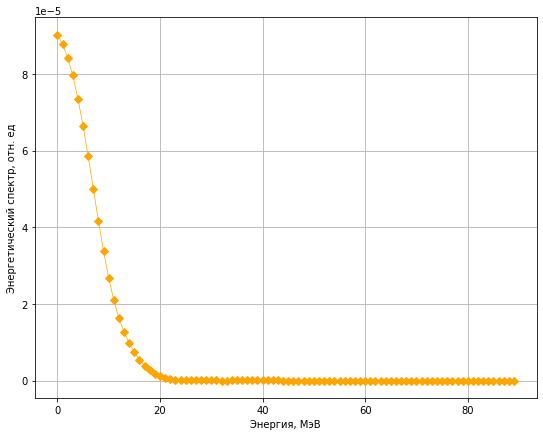

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(range(90), spectrums_signals[0][0], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Скрипт

In [20]:
SP, DEV = [], []

for j in range(len(brems_e)):
    sp, dev = deconvolution_one_spectrum(brems_e[j], spectrums_signals[j])
    SP.append(sp)
    DEV.append(dev)
    print(f'ВЫПОЛНЕНО {j+1} из {len(brems_e)}')

(0), время: 0.0 секунд
(1), время: 5.91966 секунд
(2), время: 11.80394 секунд
(3), время: 17.81982 секунд
(4), время: 23.67995 секунд
(5), время: 29.53869 секунд
(6), время: 35.50886 секунд
(7), время: 41.39797 секунд
(8), время: 47.24672 секунд
(9), время: 53.12264 секунд
(10), время: 59.02222 секунд
(11), время: 64.91007 секунд
(12), время: 70.81017 секунд
(13), время: 76.69963 секунд
(14), время: 82.59349 секунд
(15), время: 88.70336 секунд
(16), время: 94.65087 секунд
(17), время: 100.88889 секунд
(18), время: 107.15585 секунд
(19), время: 113.08997 секунд
(20), время: 118.95399 секунд
(21), время: 124.81702 секунд
(22), время: 130.6937 секунд
(23), время: 136.556 секунд
(24), время: 142.42894 секунд
(25), время: 148.32358 секунд
(26), время: 154.41334 секунд
(27), время: 160.50746 секунд
(28), время: 166.45846 секунд
(29), время: 172.53222 секунд
(30), время: 178.60851 секунд
(31), время: 184.6852 секунд
(32), время: 190.74628 секунд
(33), время: 196.78749 секунд
(34), время: 202.

(75), время: 441.40772 секунд
(76), время: 447.29697 секунд
(77), время: 453.19276 секунд
(78), время: 459.11706 секунд
(79), время: 465.02192 секунд
(80), время: 470.91139 секунд
(81), время: 476.80064 секунд
(82), время: 482.71651 секунд
(83), время: 488.59013 секунд
(84), время: 494.52623 секунд
(85), время: 500.49218 секунд
(86), время: 506.4439 секунд
(87), время: 512.35712 секунд
(88), время: 518.31278 секунд
(89), время: 524.21765 секунд
(90), время: 530.14815 секунд
(91), время: 536.08426 секунд
(92), время: 541.99454 секунд
(93), время: 547.92375 секунд
(94), время: 553.82862 секунд
(95), время: 559.84367 секунд
(96), время: 565.74853 секунд
(97), время: 571.68464 секунд
(98), время: 577.65555 секунд
(99), время: 583.57604 секунд
(100), время: 589.4394 секунд
ВЫПОЛНЕНО 3 из 50
(0), время: 0.0 секунд
(1), время: 5.83308 секунд
(2), время: 11.6527 секунд
(3), время: 17.49508 секунд
(4), время: 23.39423 секунд
(5), время: 29.2991 секунд
(6), время: 35.17272 секунд
(7), время: 41.

(48), время: 283.52727 секунд
(49), время: 289.53739 секунд
(50), время: 295.43524 секунд
(51), время: 301.3678 секунд
(52), время: 307.30498 секунд
(53), время: 313.20772 секунд
(54), время: 319.08742 секунд
(55), время: 324.96055 секунд
(56), время: 330.84857 секунд
(57), время: 336.76614 секунд
(58), время: 342.63278 секунд
(59), время: 348.54882 секунд
(60), время: 354.46818 секунд
(61), время: 360.38615 секунд
(62), время: 366.27491 секунд
(63), время: 372.14932 секунд
(64), время: 378.03671 секунд
(65), время: 383.92511 секунд
(66), время: 389.78555 секунд
(67), время: 395.63698 секунд
(68), время: 401.52464 секунд
(69), время: 407.45684 секунд
(70), время: 413.36084 секунд
(71), время: 419.26476 секунд
(72), время: 425.164 секунд
(73), время: 431.08917 секунд
(74), время: 437.01498 секунд
(75), время: 442.91451 секунд
(76), время: 448.79252 секунд
(77), время: 454.67917 секунд
(78), время: 460.58261 секунд
(79), время: 466.45404 секунд
(80), время: 472.39794 секунд
(81), время: 

(21), время: 123.19651 секунд
(22), время: 129.04741 секунд
(23), время: 134.88699 секунд
(24), время: 140.71486 секунд
(25), время: 146.59447 секунд
(26), время: 152.45206 секунд
(27), время: 158.31331 секунд
(28), время: 164.25466 секунд
(29), время: 170.09639 секунд
(30), время: 175.9779 секунд
(31), время: 181.90689 секунд
(32), время: 187.84144 секунд
(33), время: 193.77506 секунд
(34), время: 199.66495 секунд
(35), время: 205.54436 секунд
(36), время: 211.43048 секунд
(37), время: 217.31104 секунд
(38), время: 223.22912 секунд
(39), время: 229.08807 секунд
(40), время: 234.96237 секунд
(41), время: 240.84286 секунд
(42), время: 246.74061 секунд
(43), время: 252.59555 секунд
(44), время: 258.45783 секунд
(45), время: 264.32762 секунд
(46), время: 270.21556 секунд
(47), время: 276.11767 секунд
(48), время: 282.0843 секунд
(49), время: 288.00372 секунд
(50), время: 293.89322 секунд
(51), время: 299.77796 секунд
(52), время: 305.68387 секунд
(53), время: 311.56134 секунд
(54), время:

(94), время: 552.8127 секунд
(95), время: 558.68313 секунд
(96), время: 564.59599 секунд
(97), время: 570.49726 секунд
(98), время: 576.45913 секунд
(99), время: 582.37912 секунд
(100), время: 588.26487 секунд
ВЫПОЛНЕНО 11 из 50
(0), время: 0.0 секунд
(1), время: 5.87172 секунд
(2), время: 11.69066 секунд
(3), время: 17.52446 секунд
(4), время: 23.3574 секунд
(5), время: 29.2067 секунд
(6), время: 35.02554 секунд
(7), время: 40.88763 секунд
(8), время: 46.73818 секунд
(9), время: 52.71439 секунд
(10), время: 58.69688 секунд
(11), время: 65.17292 секунд
(12), время: 71.34358 секунд
(13), время: 77.35115 секунд
(14), время: 83.26786 секунд
(15), время: 89.17006 секунд
(16), время: 95.03793 секунд
(17), время: 100.9209 секунд
(18), время: 106.82013 секунд
(19), время: 112.65504 секунд
(20), время: 118.55949 секунд
(21), время: 124.9408 секунд
(22), время: 131.17912 секунд
(23), время: 137.46167 секунд
(24), время: 143.72751 секунд
(25), время: 149.91679 секунд
(26), время: 155.80339 секун

(67), время: 395.02009 секунд
(68), время: 400.8924 секунд
(69), время: 406.7462 секунд
(70), время: 412.68553 секунд
(71), время: 418.5599 секунд
(72), время: 424.44827 секунд
(73), время: 430.38174 секунд
(74), время: 436.26897 секунд
(75), время: 442.17129 секунд
(76), время: 448.0893 секунд
(77), время: 453.99268 секунд
(78), время: 459.89843 секунд
(79), время: 465.81015 секунд
(80), время: 471.72809 секунд
(81), время: 477.69434 секунд
(82), время: 483.59743 секунд
(83), время: 489.484 секунд
(84), время: 495.37198 секунд
(85), время: 501.30228 секунд
(86), время: 507.22266 секунд
(87), время: 513.12664 секунд
(88), время: 519.04393 секунд
(89), время: 524.99477 секунд
(90), время: 531.00968 секунд
(91), время: 536.92742 секунд
(92), время: 542.79876 секунд
(93), время: 548.68374 секунд
(94), время: 554.60418 секунд
(95), время: 560.47662 секунд
(96), время: 566.3796 секунд
(97), время: 572.29919 секунд
(98), время: 578.20117 секунд
(99), время: 584.10337 секунд
(100), время: 590

(40), время: 234.61931 секунд
(41), время: 240.5013 секунд
(42), время: 246.38475 секунд
(43), время: 252.26649 секунд
(44), время: 258.13554 секунд
(45), время: 264.06528 секунд
(46), время: 269.98144 секунд
(47), время: 275.88283 секунд
(48), время: 281.81182 секунд
(49), время: 287.80496 секунд
(50), время: 293.73206 секунд
(51), время: 299.63311 секунд
(52), время: 305.56368 секунд
(53), время: 311.49792 секунд
(54), время: 317.44741 секунд
(55), время: 323.38197 секунд
(56), время: 329.25092 секунд
(57), время: 335.13452 секунд
(58), время: 341.01848 секунд
(59), время: 346.96701 секунд
(60), время: 352.882 секунд
(61), время: 358.73715 секунд
(62), время: 364.75733 секунд
(63), время: 370.64893 секунд
(64), время: 376.5184 секунд
(65), время: 382.38568 секунд
(66), время: 388.2524 секунд
(67), время: 394.10297 секунд
(68), время: 399.92206 секунд
(69), время: 405.85981 секунд
(70), время: 411.68789 секунд
(71), время: 417.59945 секунд
(72), время: 423.46826 секунд
(73), время: 42

(13), время: 75.90932 секунд
(14), время: 81.79091 секунд
(15), время: 87.64115 секунд
(16), время: 93.49246 секунд
(17), время: 99.31113 секунд
(18), время: 105.1435 секунд
(19), время: 110.94441 секунд
(20), время: 116.7915 секунд
(21), время: 122.68317 секунд
(22), время: 128.55612 секунд
(23), время: 134.39297 секунд
(24), время: 140.22677 секунд
(25), время: 146.07537 секунд
(26), время: 151.93139 секунд
(27), время: 157.82257 секунд
(28), время: 163.70606 секунд
(29), время: 169.57519 секунд
(30), время: 175.42583 секунд
(31), время: 181.37411 секунд
(32), время: 187.25263 секунд
(33), время: 193.1548 секунд
(34), время: 199.0248 секунд
(35), время: 204.8753 секунд
(36), время: 210.75697 секунд
(37), время: 216.62355 секунд
(38), время: 222.49162 секунд
(39), время: 228.40495 секунд
(40), время: 234.33564 секунд
(41), время: 240.30293 секунд
(42), время: 246.22102 секунд
(43), время: 252.15357 секунд
(44), время: 258.0548 секунд
(45), время: 263.97185 секунд
(46), время: 269.9034

(87), время: 521.05343 секунд
(88), время: 527.08557 секунд
(89), время: 533.06022 секунд
(90), время: 539.02971 секунд
(91), время: 545.0283 секунд
(92), время: 551.09292 секунд
(93), время: 557.20648 секунд
(94), время: 563.12697 секунд
(95), время: 569.18011 секунд
(96), время: 575.14181 секунд
(97), время: 581.14464 секунд
(98), время: 587.26125 секунд
(99), время: 593.26385 секунд
(100), время: 599.2433 секунд
ВЫПОЛНЕНО 22 из 50
(0), время: 0.0 секунд
(1), время: 5.81113 секунд
(2), время: 11.62227 секунд
(3), время: 17.44903 секунд
(4), время: 23.42526 секунд
(5), время: 29.39516 секунд
(6), время: 35.29912 секунд
(7), время: 41.4279 секунд
(8), время: 47.94803 секунд
(9), время: 55.18158 секунд
(10), время: 62.46433 секунд
(11), время: 68.87518 секунд
(12), время: 75.40472 секунд
(13), время: 81.40468 секунд
(14), время: 87.36574 секунд
(15), время: 93.57115 секунд
(16), время: 100.12463 секунд
(17), время: 106.93741 секунд
(18), время: 113.04036 секунд
(19), время: 118.89873 се

(60), время: 363.59084 секунд
(61), время: 369.7643 секунд
(62), время: 377.0247 секунд
(63), время: 383.39391 секунд
(64), время: 390.22016 секунд
(65), время: 396.56619 секунд
(66), время: 403.29575 секунд
(67), время: 409.93354 секунд
(68), время: 416.16103 секунд
(69), время: 422.03556 секунд
(70), время: 427.90213 секунд
(71), время: 433.75314 секунд
(72), время: 439.60829 секунд
(73), время: 445.49516 секунд
(74), время: 451.32143 секунд
(75), время: 457.1925 секунд
(76), время: 463.06517 секунд
(77), время: 468.99891 секунд
(78), время: 474.8952 секунд
(79), время: 480.78229 секунд
(80), время: 486.65528 секунд
(81), время: 492.57287 секунд
(82), время: 498.45968 секунд
(83), время: 504.36419 секунд
(84), время: 510.23498 секунд
(85), время: 516.11883 секунд
(86), время: 522.00561 секунд
(87), время: 527.95898 секунд
(88), время: 533.86709 секунд
(89), время: 539.77426 секунд
(90), время: 545.66082 секунд
(91), время: 551.59437 секунд
(92), время: 557.49627 секунд
(93), время: 5

(33), время: 199.07216 секунд
(34), время: 205.13423 секунд
(35), время: 211.08996 секунд
(36), время: 217.03007 секунд
(37), время: 222.91147 секунд
(38), время: 228.76426 секунд
(39), время: 234.64988 секунд
(40), время: 240.53608 секунд
(41), время: 246.43718 секунд
(42), время: 252.29464 секунд
(43), время: 258.17826 секунд
(44), время: 264.03072 секунд
(45), время: 269.91651 секунд
(46), время: 275.85611 секунд
(47), время: 281.92173 секунд
(48), время: 287.89793 секунд
(49), время: 293.84002 секунд
(50), время: 299.87975 секунд
(51), время: 305.78293 секунд
(52), время: 311.71135 секунд
(53), время: 317.63826 секунд
(54), время: 323.56563 секунд
(55), время: 329.47757 секунд
(56), время: 335.42083 секунд
(57), время: 341.3488 секунд
(58), время: 347.26991 секунд
(59), время: 353.16919 секунд
(60), время: 359.08344 секунд
(61), время: 364.9517 секунд
(62), время: 370.81793 секунд
(63), время: 376.66827 секунд
(64), время: 382.53114 секунд
(65), время: 388.38142 секунд
(66), время:

(5), время: 29.72019 секунд
(6), время: 35.67291 секунд
(7), время: 41.62573 секунд
(8), время: 47.56274 секунд
(9), время: 53.51336 секунд
(10), время: 59.46581 секунд
(11), время: 65.40304 секунд
(12), время: 71.3706 секунд
(13), время: 77.32486 секунд
(14), время: 83.27815 секунд
(15), время: 89.27978 секунд
(16), время: 95.29963 секунд
(17), время: 101.28773 секунд
(18), время: 107.25689 секунд
(19), время: 113.2426 секунд
(20), время: 119.22647 секунд
(21), время: 125.17997 секунд
(22), время: 131.14744 секунд
(23), время: 137.1311 секунд
(24), время: 143.11633 секунд
(25), время: 149.11638 секунд
(26), время: 155.10219 секунд
(27), время: 161.08631 секунд
(28), время: 167.039 секунд
(29), время: 173.02218 секунд
(30), время: 178.99155 секунд
(31), время: 184.97551 секунд
(32), время: 190.94463 секунд
(33), время: 196.91091 секунд
(34), время: 202.89493 секунд
(35), время: 208.90288 секунд
(36), время: 214.89403 секунд
(37), время: 220.86781 секунд
(38), время: 226.85162 секунд
(3

(79), время: 472.1142 секунд
(80), время: 477.98424 секунд
(81), время: 483.83577 секунд
(82), время: 489.7178 секунд
(83), время: 495.60136 секунд
(84), время: 501.50158 секунд
(85), время: 507.35407 секунд
(86), время: 513.22099 секунд
(87), время: 519.11953 секунд
(88), время: 525.06714 секунд
(89), время: 531.03285 секунд
(90), время: 536.96548 секунд
(91), время: 542.89775 секунд
(92), время: 548.7988 секунд
(93), время: 554.83929 секунд
(94), время: 560.80166 секунд
(95), время: 566.76072 секунд
(96), время: 572.643 секунд
(97), время: 578.53948 секунд
(98), время: 584.43706 секунд
(99), время: 590.31745 секунд
(100), время: 596.19908 секунд
ВЫПОЛНЕНО 33 из 50
(0), время: 0.0 секунд
(1), время: 5.83558 секунд
(2), время: 11.68447 секунд
(3), время: 17.56497 секунд
(4), время: 23.44843 секунд
(5), время: 29.33309 секунд
(6), время: 35.24784 секунд
(7), время: 41.15104 секунд
(8), время: 47.0659 секунд
(9), время: 52.99942 секунд
(10), время: 58.93478 секунд
(11), время: 64.90156 с

(52), время: 311.36553 секунд
(53), время: 317.76915 секунд
(54), время: 324.31515 секунд
(55), время: 330.76361 секунд
(56), время: 337.14575 секунд
(57), время: 343.46073 секунд
(58), время: 349.71543 секунд
(59), время: 355.9289 секунд
(60), время: 362.132 секунд
(61), время: 368.1867 секунд
(62), время: 374.20333 секунд
(63), время: 380.22161 секунд
(64), время: 386.26909 секунд
(65), время: 392.28948 секунд
(66), время: 398.29033 секунд
(67), время: 404.30639 секунд
(68), время: 410.34132 секунд
(69), время: 416.34214 секунд
(70), время: 422.35958 секунд
(71), время: 428.3769 секунд
(72), время: 434.44614 секунд
(73), время: 440.52331 секунд
(74), время: 446.54834 секунд
(75), время: 452.6155 секунд
(76), время: 458.66834 секунд
(77), время: 464.76728 секунд
(78), время: 470.85194 секунд
(79), время: 476.95255 секунд
(80), время: 483.08491 секунд
(81), время: 489.21633 секунд
(82), время: 495.31848 секунд
(83), время: 501.42231 секунд
(84), время: 507.51129 секунд
(85), время: 513

(25), время: 146.2111 секунд
(26), время: 152.08359 секунд
(27), время: 157.91909 секунд
(28), время: 163.81516 секунд
(29), время: 169.66692 секунд
(30), время: 175.52058 секунд
(31), время: 181.43828 секунд
(32), время: 187.29984 секунд
(33), время: 193.18176 секунд
(34), время: 199.03115 секунд
(35), время: 204.88249 секунд
(36), время: 210.71633 секунд
(37), время: 216.59888 секунд
(38), время: 222.46873 секунд
(39), время: 228.36959 секунд
(40), время: 234.27287 секунд
(41), время: 240.17604 секунд
(42), время: 246.11089 секунд
(43), время: 252.04666 секунд
(44), время: 258.10976 секунд
(45), время: 264.08691 секунд
(46), время: 270.06925 секунд
(47), время: 276.08447 секунд
(48), время: 282.08282 секунд
(49), время: 288.06511 секунд
(50), время: 294.06342 секунд
(51), время: 300.12911 секунд
(52), время: 306.14407 секунд
(53), время: 312.17492 секунд
(54), время: 318.17273 секунд
(55), время: 324.1561 секунд
(56), время: 330.17096 секунд
(57), время: 336.24805 секунд
(58), время:

(98), время: 583.23339 секунд
(99), время: 589.26607 секунд
(100), время: 595.2961 секунд
ВЫПОЛНЕНО 41 из 50
(0), время: 0.0 секунд
(1), время: 5.98426 секунд
(2), время: 11.95246 секунд
(3), время: 17.93749 секунд
(4), время: 23.95283 секунд
(5), время: 29.95421 секунд
(6), время: 35.94101 секунд
(7), время: 41.95717 секунд
(8), время: 47.94438 секунд
(9), время: 54.01047 секунд
(10), время: 60.07959 секунд
(11), время: 66.11032 секунд
(12), время: 72.16078 секунд
(13), время: 78.1817 секунд
(14), время: 84.21836 секунд
(15), время: 90.23756 секунд
(16), время: 96.25867 секунд
(17), время: 102.30914 секунд
(18), время: 108.34501 секунд
(19), время: 114.36533 секунд
(20), время: 120.35041 секунд
(21), время: 126.2552 секунд
(22), время: 132.12817 секунд
(23), время: 137.99507 секунд
(24), время: 143.82475 секунд
(25), время: 149.6802 секунд
(26), время: 155.56272 секунд
(27), время: 161.41624 секунд
(28), время: 167.25081 секунд
(29), время: 173.15388 секунд
(30), время: 179.09411 секу

(71), время: 422.09099 секунд
(72), время: 427.93976 секунд
(73), время: 433.77661 секунд
(74), время: 439.62529 секунд
(75), время: 445.50829 секунд
(76), время: 451.36278 секунд
(77), время: 457.2122 секунд
(78), время: 463.09424 секунд
(79), время: 468.93029 секунд
(80), время: 474.81507 секунд
(81), время: 480.73225 секунд
(82), время: 486.63326 секунд
(83), время: 492.56579 секунд
(84), время: 498.53162 секунд
(85), время: 504.45032 секунд
(86), время: 510.41502 секунд
(87), время: 516.41384 секунд
(88), время: 522.44817 секунд
(89), время: 528.53802 секунд
(90), время: 534.53145 секунд
(91), время: 540.53108 секунд
(92), время: 546.54666 секунд
(93), время: 552.56301 секунд
(94), время: 558.56098 секунд
(95), время: 564.56323 секунд
(96), время: 570.56065 секунд
(97), время: 576.86672 секунд
(98), время: 582.52079 секунд
(99), время: 588.32533 секунд
(100), время: 594.50858 секунд
ВЫПОЛНЕНО 44 из 50
(0), время: 0.0 секунд
(1), время: 6.03624 секунд
(2), время: 12.10147 секунд
(3)

(44), время: 263.37636 секунд
(45), время: 269.42903 секунд
(46), время: 275.49668 секунд
(47), время: 281.64511 секунд
(48), время: 287.72829 секунд
(49), время: 293.74743 секунд
(50), время: 299.72902 секунд
(51), время: 305.62764 секунд
(52), время: 311.47931 секунд
(53), время: 317.34181 секунд
(54), время: 323.22393 секунд
(55), время: 329.10322 секунд
(56), время: 334.98338 секунд
(57), время: 340.83227 секунд
(58), время: 346.72908 секунд
(59), время: 352.61034 секунд
(60), время: 358.47767 секунд
(61), время: 364.32584 секунд
(62), время: 370.17533 секунд
(63), время: 376.00749 секунд
(64), время: 381.85644 секунд
(65), время: 387.73858 секунд
(66), время: 393.57199 секунд
(67), время: 399.49101 секунд
(68), время: 405.35729 секунд
(69), время: 411.20755 секунд
(70), время: 417.02614 секунд
(71), время: 422.87714 секунд
(72), время: 428.75977 секунд
(73), время: 434.6434 секунд
(74), время: 440.51289 секунд
(75), время: 446.36393 секунд
(76), время: 452.2315 секунд
(77), время:

(17), время: 99.20157 секунд
(18), время: 105.08519 секунд
(19), время: 111.00102 секунд
(20), время: 116.91857 секунд
(21), время: 122.78714 секунд
(22), время: 128.70299 секунд
(23), время: 134.63512 секунд
(24), время: 140.53815 секунд
(25), время: 146.43907 секунд
(26), время: 152.388 секунд
(27), время: 158.35947 секунд
(28), время: 164.31388 секунд
(29), время: 170.28615 секунд
(30), время: 176.26944 секунд
(31), время: 182.23588 секунд
(32), время: 188.20264 секунд
(33), время: 194.18446 секунд
(34), время: 200.13502 секунд
(35), время: 206.08646 секунд
(36), время: 212.06934 секунд
(37), время: 218.05139 секунд
(38), время: 224.06536 секунд
(39), время: 230.03516 секунд
(40), время: 236.13626 секунд
(41), время: 242.10525 секунд
(42), время: 248.07414 секунд
(43), время: 254.04424 секунд
(44), время: 260.02997 секунд
(45), время: 266.01464 секунд
(46), время: 272.03284 секунд
(47), время: 278.16728 секунд
(48), время: 284.26353 секунд
(49), время: 290.31225 секунд
(50), время: 

Сохранение данных

In [21]:
np.save(f'K_{m}_SP.npy', SP)
np.save(f'K_{m}_DEV.npy', DEV)

Загрузка данных

Построение

In [22]:
from mpl_toolkits.mplot3d import Axes3D

In [23]:
D = np.array(DEV)
X,Y = np.meshgrid(edge_max_values, beams_energyes)
X, Ylog = np.meshgrid(edge_max_values, np.log10(beams_energyes))
Xlog, Ylog = np.meshgrid(np.log10(edge_max_values), np.log10(beams_energyes))

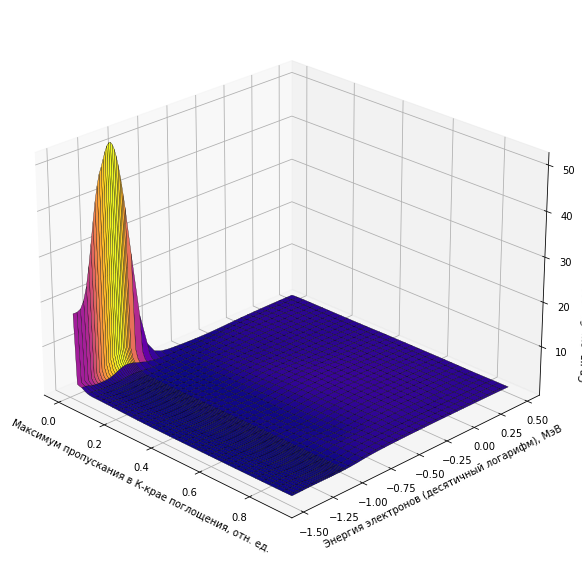

In [24]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(X, Ylog, D, cmap='plasma', linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов (десятичный логарифм), МэВ')
ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

# угол зрения (линейный)
# ax.view_init(elev=20, azim=-135)

# угол зрения (логарифм)
ax.view_init(elev=25, azim=-45)

# fig.savefig('К_фильтры_3D.jpg', bbox_inches='tight')

Контурная карта

In [25]:
linspace4 = np.geomspace(1e-2, 0.3, 20)
linspace5 = np.linspace(0.31, 1.4, 10)

In [26]:
c_map_levels = []
c_map_levels.extend(linspace4)
c_map_levels.extend(linspace5)

Text(0, 0.5, 'Энергия электронов, МэВ')

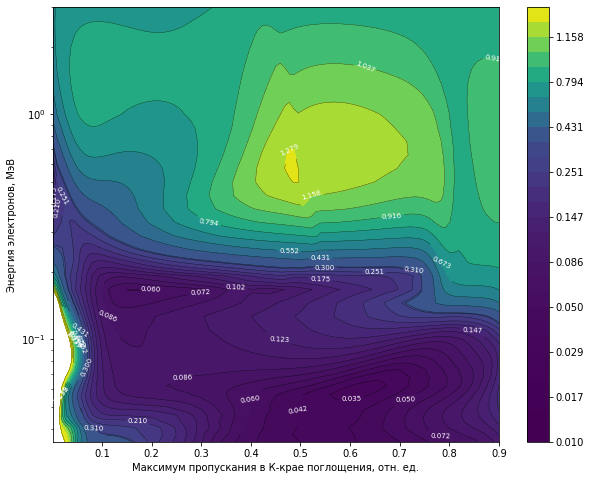

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

c_map = ax.contourf(X, Y, D, levels=c_map_levels)
borders = ax.contour(X, Y, D, colors='k', levels=c_map_levels, linewidths=0.3)
ax.clabel(borders, fontsize=7, colors='w')
fig.colorbar(c_map)
ax.set_yscale('log')

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')

# fig.savefig('К_фильтры_контурная_карта.jpg', bbox_inches='tight')

Зависимость минимальной ошибки восстановления от граничной энерии спектра

In [28]:
minimal_deviations = []

for i,val in enumerate(beams_energyes):
    min_value = min(DEV[i])
    minimal_deviations.append(min_value)

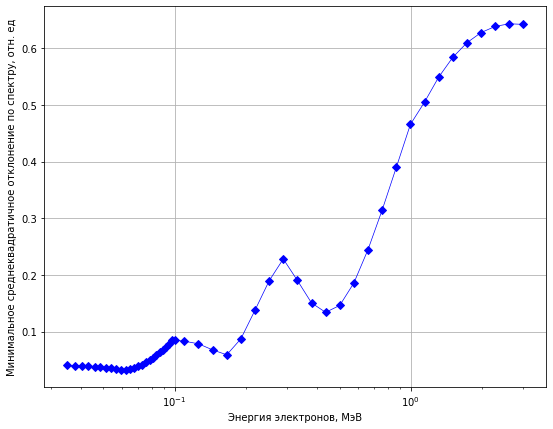

In [29]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, minimal_deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('К_фильтры_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')

In [30]:
np.save(f'K_{m}_MIN.npy', minimal_deviations)